# Unsupervised Learning Final Project

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

In this project, we will examine three different dimensionality reduction approaches using standard **PCA**, **PCA + T-distributed Stochastic Neighbor Embedding** and **PCA + Uniform Manifold Approximation and Projection** on the Fashion-MNIST database and compare the results. We will limit the exploration to Unsupervised clustering algorithms. Since we have labels for Fashion-MNIST, it is relatively trivial to train a cluster algorithm with the help of labels, bake the labels into the model and then use it for prediction. Hence, the supervised learning approach will not be explored here.

In [ ]:
%pip install pandas numpy scikit-learn matplotlib seaborn kagglehub umap-learn scipy

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import umap
import kagglehub

from kagglehub import KaggleDatasetAdapter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score, normalized_mutual_info_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import IsolationForest

## Exploratory Data Analysis

In [16]:
train_file_path = "fashion-mnist_train.csv"

fashion = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "zalando-research/fashionmnist",
  train_file_path
)

X_train = fashion.drop('label', axis=1).values.astype(np.float32)

y_train = fashion['label'].values.astype(int)

print(f"Data shape: {X_train.shape}, Labels shape: {y_train.shape}")

/var/folders/mp/vmnrbyxx37d22qffx8lh76nc0000gn/T/ipykernel_43024/1822692165.py:3: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  fashion = kagglehub.load_dataset(


Data shape: (60000, 784), Labels shape: (60000,)


Fashion-MNIST is a list of 60000 images and is highly uniform and clean. This creates some unique challenges. It is unnecessary to look for skewed data or missing values. However, the images themselves have anomalies. Also, the large number of images, while useful for research, is overkill for the purposes of this project. 

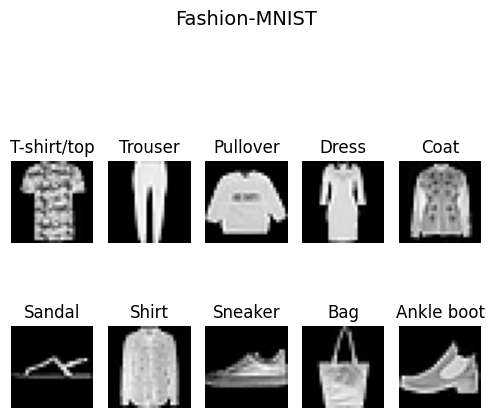

In [17]:
fashion_mnist_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(5, 5))
n_classes = len(fashion_mnist_labels)
for cls in range(n_classes):
    idx = np.where(y_train == cls)[0][0]
    plt.subplot(2, 5, cls + 1)
    plt.imshow(X_train[idx].reshape(28, 28), cmap='gray')
    plt.title(fashion_mnist_labels[cls])
    plt.axis('off')
plt.suptitle("Fashion-MNIST", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

The algorithms we use for exploration are time and resource intensive. It would make sense to use a subset for these explorations. However, we would also like to not skew the data and ensure the subset is representative of the entire dataset.

We will use `StratifiedShuffleSplit` to get a training and testing subset of 1000 samples each. 

In [18]:
# Flatten images for dimensionality reduction
X_flat = X_train.reshape((X_train.shape[0], -1))

# Stratified sampling to preserve class distribution
sss = StratifiedShuffleSplit(n_splits=1, train_size=1000, test_size=1000, random_state=42)
for subset_idx, _ in sss.split(X_flat, y_train):
    X_subset = X_flat[subset_idx]
    y_subset = y_train[subset_idx]

print(f"subset shape: {X_subset.shape}, class distribution: {np.bincount(y_subset)}")

subset shape: (1000, 784), class distribution: [100 100 100 100 100 100 100 100 100 100]


Given this subset, we will now look for anomalies in the subset and remove outliers. **Isolation Forest** is an unsupervised machine learning algorithm that identifies anomalies or outliers in data by isolating them through a process of random partitioning within a collection of decision trees.

We will use `IsolationForest` from sklearn to identify the outliers and remove them  

In [19]:
iso = IsolationForest(contamination=0.01, random_state=42)
outlier_pred = iso.fit_predict(X_subset)
mask = outlier_pred == 1
X_clean = X_subset[mask]
y_clean = y_subset[mask]

In [20]:
X_clean.shape

(990, 784)

Now every data point in the dataset has 784 dimensions which are the number of pixels in the image. However, 784 dimensions are not necessary and it maybe possible to tune the number of dimensions to a lower level to make the model training much more efficient

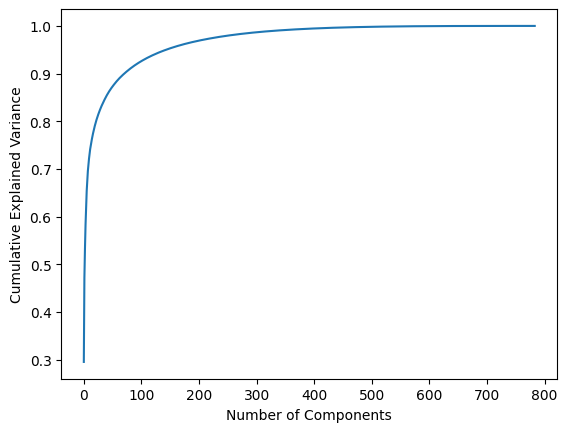

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA().fit(X_clean)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


The above graph shows that the curve levels of at 95% variance for around 200 components. This means that beyond 200 dimensions, very little information is added and higher dimensions can be ignored.

Here we define two reporting functions:
1. A function to plot the clusters generated with each approach
2. A function to calculate the following metrics
    - Adjusted Rand Index (ARI)
    - Silhouette score
    - Normalized Mutual Info score (NMI)

#### Adjusted Rand Index
The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. The raw RI score is then “adjusted for chance” into the ARI score

#### Silhouette score
The Silhouette score is a metric used to evaluate the quality of clustering results, particularly in scenarios where the ground truth of the data is unknown.

#### Normalized Mutual Info score
Normalized Mutual Information (NMI) is a metric used to evaluate the similarity between two clusterings of the same dataset. It is a normalized version of Mutual Information (MI), which measures the amount of information shared between two assignments (such as predicted clusters and ground truth labels). NMI scales the MI score to a range between 0 and 1, where:
  
  - 0 indicates no mutual information (completely independent clusterings)
  - 1 indicates perfect correlation (identical clusterings, up to label permutations)

In [22]:
# Reporting functions

# Plotting function
def plot_embedding(X_embedded, y_true, clusters, title):
    unique_labels = np.unique(y_true)
    unique_clusters = np.unique(clusters)
    colors = plt.cm.tab10.colors

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Left: True labels with label names
    for idx, label in enumerate(unique_labels):
        mask = y_true == label
        axes[0].scatter(X_embedded[mask, 0], X_embedded[mask, 1],
                        color=colors[idx % len(colors)], label=fashion_mnist_labels[label], s=20, alpha=0.7)
    axes[0].set_title(f"{title} - True Labels")
    axes[0].set_xlabel("Component 1")
    axes[0].set_ylabel("Component 2")
    axes[0].legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Right: KMeans clusters with cluster numbers
    for idx, cluster in enumerate(unique_clusters):
        mask = clusters == cluster
        axes[1].scatter(X_embedded[mask, 0], X_embedded[mask, 1],
                        color=colors[idx % len(colors)], label=f"Cluster {cluster}", s=20, alpha=0.7)
    axes[1].set_title(f"{title} - KMeans Clusters")
    axes[1].set_xlabel("Component 1")
    axes[1].set_ylabel("Component 2")
    axes[1].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Function to display metrics
def print_metrics(y_true, clusters, X_embedded, method):
    ari = adjusted_rand_score(y_true, clusters)
    sil = silhouette_score(X_embedded, clusters)
    nmi = normalized_mutual_info_score(y_true, clusters)
    print(f"{method}: Adjusted Rand Index = {ari:.3f}")
    print(f"Silhouette Score = {sil:.3f}")
    print(f"Normalized Mutual Info Score = {nmi:.3f}")

## Model Training

We will examine three different clustering approaches using standard **PCA**, **PCA + T-distributed Stochastic Neighbor Embedding** and **PCA + Uniform Manifold Approximation and Projection** on the Fashion-MNIST database

### PCA + K-means

Here we will perform dimensionality reductions with PCA and then apply the K-means clustering algorithm. As we identified earlier, we will reduce the dimensions to 200 and then pass it to the K-means algorithm

In [23]:
pca_200 = PCA(n_components=200, random_state=42)
X_pca_200 = pca_200.fit_transform(X_clean)

kmeans_pca = KMeans(n_clusters=10, random_state=42).fit(X_pca_200)
clusters_pca = kmeans_pca.labels_

# For visualization: reduce to 2D
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_clean)

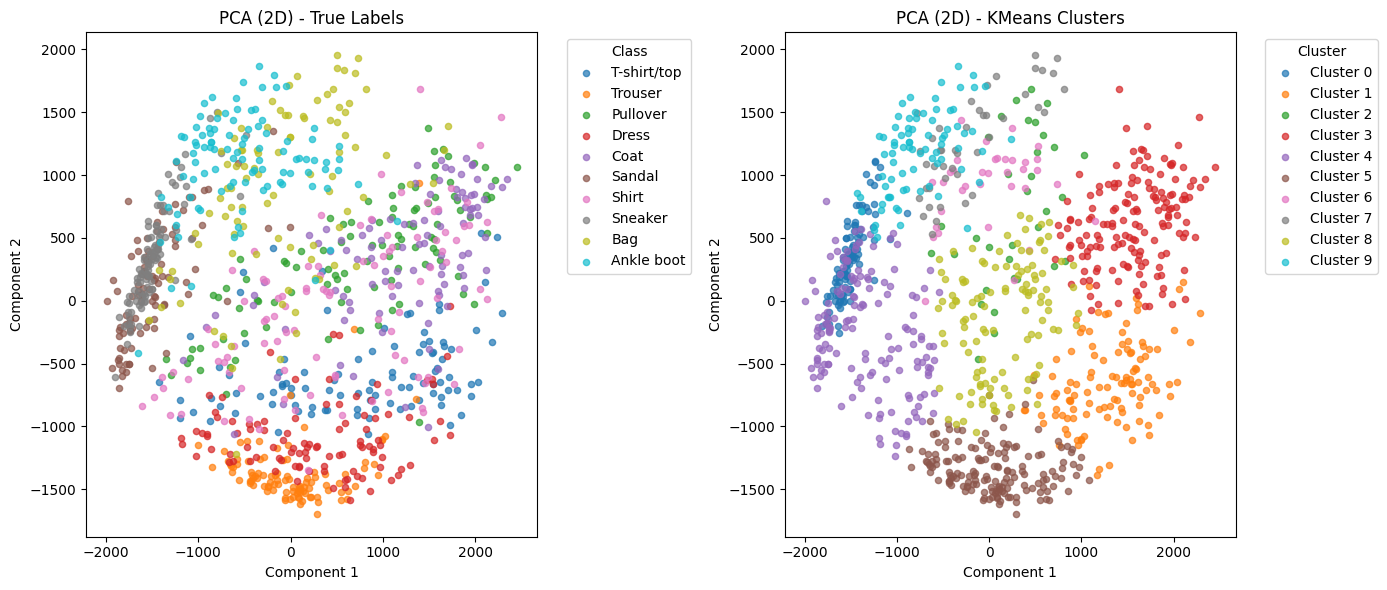

PCA (2D): Adjusted Rand Index = 0.368
Silhouette Score = 0.242
Normalized Mutual Info Score = 0.544


In [24]:
plot_embedding(X_pca_2d, y_clean, clusters_pca, "PCA (2D)")
print_metrics(y_clean, clusters_pca, X_pca_2d, "PCA (2D)")

The low Silhouette score means that the clusters are not sufficiently separated. It is also apparent from the graph that the clustering is virtually non-existent based on the true labels.

### PCA + t-SNE

t-distributed stochastic neighbor embedding (t-SNE) is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map.

In [25]:
pca_200 = PCA(n_components=200, random_state=42)
X_pca_200 = pca_200.fit_transform(X_clean)

kmeans_tsne = KMeans(n_clusters=10, random_state=42).fit(X_pca_200)
clusters_tsne = kmeans_tsne.labels_

tsne_2d = TSNE(n_components=2, random_state=42, init='pca')
X_tsne_2d = tsne_2d.fit_transform(X_pca_200)

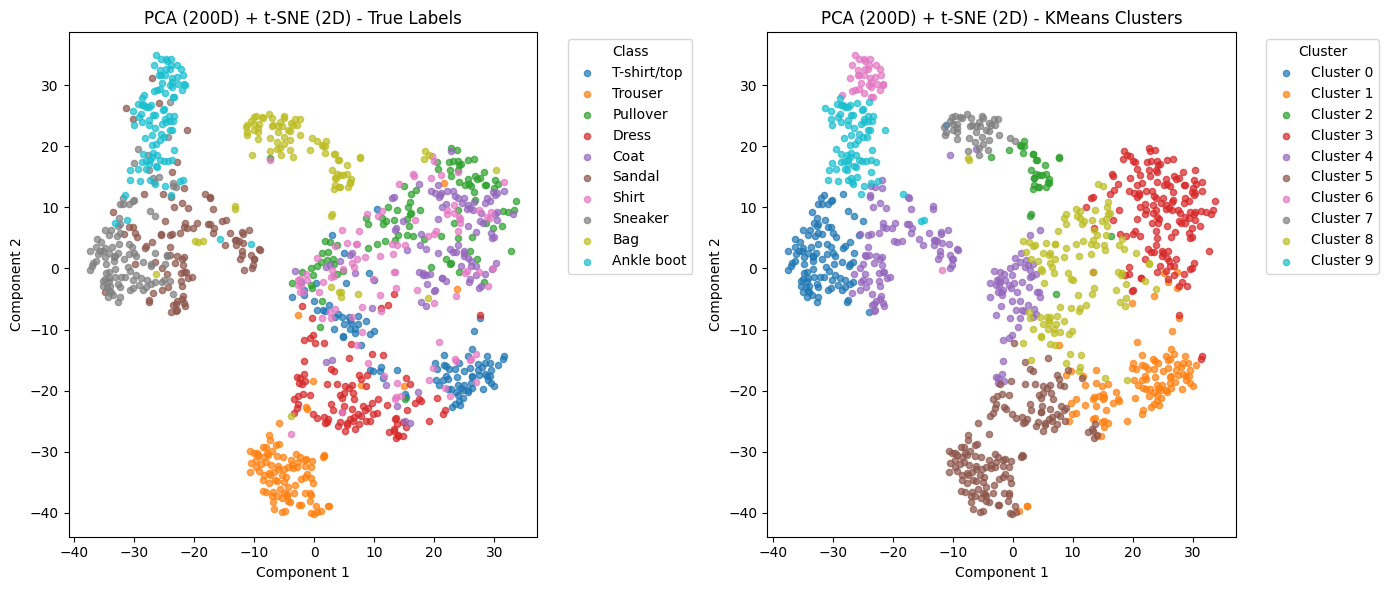

PCA (200D) + t-SNE (2D): Adjusted Rand Index = 0.368
Silhouette Score = 0.345
Normalized Mutual Info Score = 0.544


In [26]:
plot_embedding(X_tsne_2d, y_clean, clusters_tsne, "PCA (200D) + t-SNE (2D)")
print_metrics(y_clean, clusters_tsne, X_tsne_2d, "PCA (200D) + t-SNE (2D)")

The Silhouette score is now significantly higher and the clusters are visibly separated. However there are some interesting observations here. The clustering algorithm seems to have a hard time differentiating between T-shirt/top, Dress, Pullover, Coat and Shirt. This is understandable since even humans would have a tough time differentiating them in certain cases. However, the algorithm is able to sufficiently differentiate between clothes, footwear and accessories.

### PCA + UMAP

Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction.

In [ ]:
pca_300 = PCA(n_components=300, random_state=42)
X_pca_300 = pca_300.fit_transform(X_clean)

kmeans_umap = KMeans(n_clusters=10, random_state=42).fit(X_pca_300)
clusters_umap = kmeans_umap.labels_

umap_2d = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.0, random_state=42)
X_umap_2d = umap_2d.fit_transform(X_pca_300)

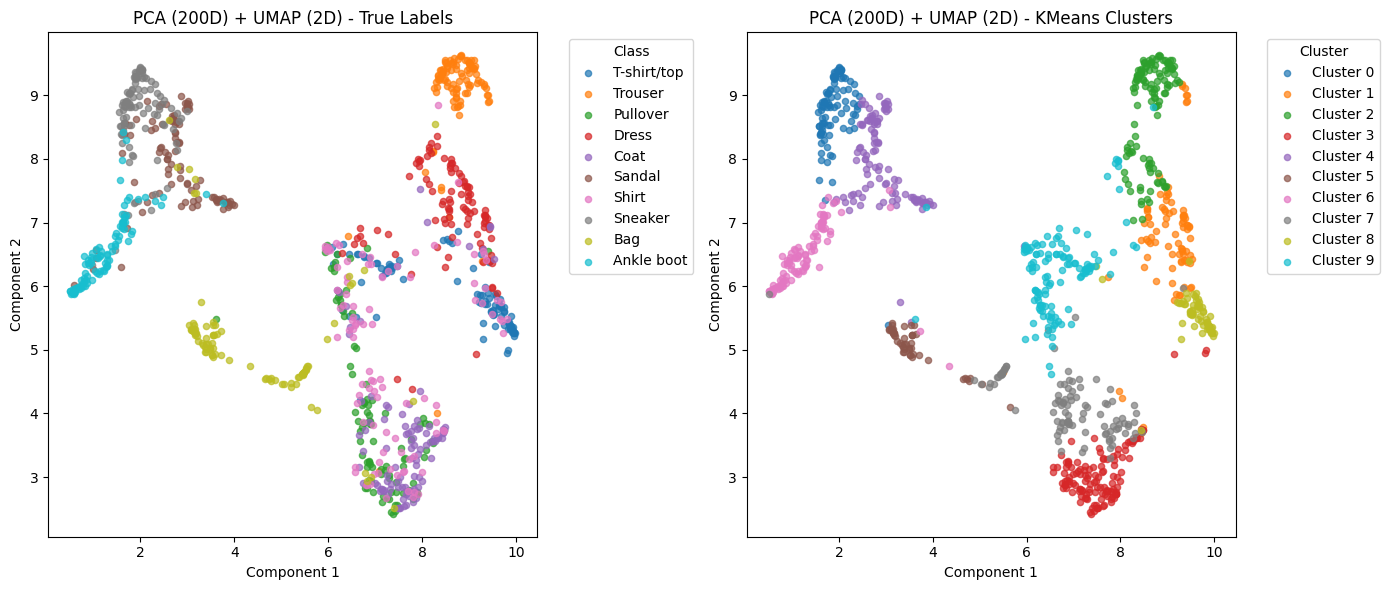

PCA (200D) + UMAP (2D): Adjusted Rand Index = 0.397
Silhouette Score = 0.413
Normalized Mutual Info Score = 0.553


In [34]:
plot_embedding(X_umap_2d, y_clean, clusters_umap, "PCA (200D) + UMAP (2D)")
print_metrics(y_clean, clusters_umap, X_umap_2d, "PCA (200D) + UMAP (2D)")

The Silhouette score is now higher than both of the previous dimensionality reduction techniques. The cluster separation is also significantly higher. However the clustering algorithm still seems to have a hard time differentiating between T-shirt/top, Dress, Pullover, Coat and Shirt. 

## Conclusions

Modern Dimensionality Reduction techniques can significantly improve the clustering results. However, the Silhouette score being less that 0.5 makes it "weak" and the NMI score of 0.553 is also quite low.

New research shows that several Deep clustering techniques can raise the NMI score to 0.64 and higher. As of 2025, Deep Clustering via Probabilistic Ratio-Cut Optimization has the highest NMI on the Fashion-MNIST data at 0.758.

## References
- Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. [arXiv:1708.07747](https://arxiv.org/abs/1708.07747)
- [Isolation Forest Guide: Explanation and Python Implementation](https://www.datacamp.com/tutorial/isolation-forest) 
- Geoffrey Hinton and Sam Roweis. 2002. Stochastic neighbor embedding. In Proceedings of the 16th International Conference on Neural Information Processing Systems (NIPS'02). MIT Press, Cambridge, MA, USA, 857–864.
- McInnes, L, Healy, J, UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction, [ArXiv e-prints 1802.03426](https://arxiv.org/abs/1802.03426), 2018
- [Image Clustering on Fashion-MNIST](https://paperswithcode.com/sota/image-clustering-on-fashion-mnist) 